<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
AAPL = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AAPL.csv")
TSLA = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_TSLA.csv")
GOOG = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_MSFT.csv")
AMZN = pd.read_csv("/content/drive/MyDrive/Database/Pre_Processed_AMZN.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

In [4]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj. Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [5]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [6]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [7]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

In [8]:
Test_Stationarity(AAPL)

Results of Dickey Fuller Test
Test Statistics: 1.120722206443355
p-value: 0.9953896550774386
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

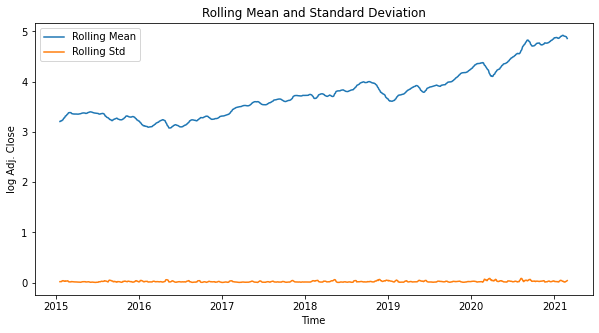

In [9]:
AAPL['log Adj. Close'] = np.log(AAPL['Adj. Close'])
AAPL_log_moving_avg = AAPL['log Adj. Close'].rolling(12).mean()
AAPL_log_std = AAPL['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(AAPL['Date'], AAPL_log_moving_avg, label = "Rolling Mean")
plt.plot(AAPL['Date'], AAPL_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set

    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26







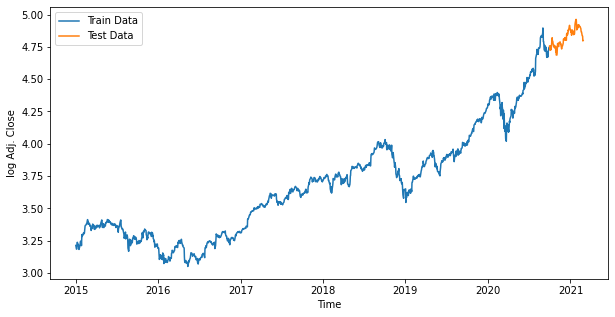

In [10]:
AAPL_Train_Data = AAPL[AAPL['Date'] < '2020-10-01']
AAPL_Test_Data = AAPL[AAPL['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(AAPL_Train_Data['Date'], AAPL_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(AAPL_Test_Data['Date'], AAPL_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [11]:
AAPL_Auto_ARIMA_Model = auto_arima(AAPL_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(AAPL_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3721.627
Date:                Wed, 03 Mar 2021   AIC                          -7437.254
Time:                        09:13:01   BIC                          -7421.424
Sample:                             0   HQIC                         -7431.346
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      2.366      0.018       0.000       0.002
ar.L1         -0.0981      0.015     -6.535      0.000      -0.127      -0.069
sigma2         0.0003   6.51e-06     52.314      0.0

In [12]:
AAPL_ARIMA_Model = ARIMA(AAPL_Train_Data['log Adj. Close'], order = (1, 1, 0))
AAPL_ARIMA_Model_Fit = AAPL_ARIMA_Model.fit()
print(AAPL_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.log Adj. Close   No. Observations:                 1446
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3721.627
Method:                       css-mle   S.D. of innovations              0.018
Date:                Wed, 03 Mar 2021   AIC                          -7437.254
Time:                        09:13:01   BIC                          -7421.424
Sample:                             1   HQIC                         -7431.346
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0011      0.000      2.405      0.016       0.000       0.002
ar.L1.D.log Adj. Close    -0.0982      0.026     -3.748      0.000      -0.150      -0.047
    

###Predicting the closing stock price of Apple

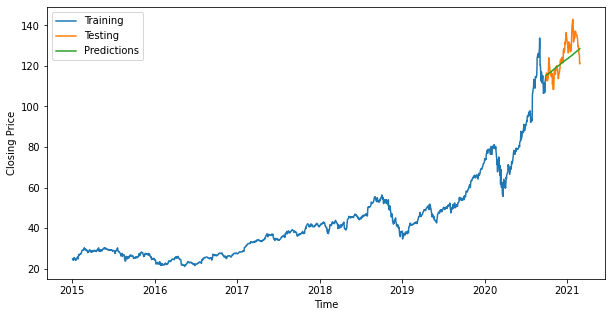

In [13]:
AAPL_output = AAPL_ARIMA_Model_Fit.forecast(102, alpha=0.05)
AAPL_predictions = np.exp(AAPL_output[0])
plt.figure(figsize=(10, 5))
plt.plot(AAPL_Train_Data['Date'], AAPL_Train_Data['Adj. Close'], label = 'Training')
plt.plot(AAPL_Test_Data['Date'], AAPL_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(AAPL_Test_Data['Date'], AAPL_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [14]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Data['Adj. Close'], AAPL_predictions))
mape = np.mean(np.abs(AAPL_predictions - AAPL_Test_Data['Adj. Close'])/np.abs(AAPL_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 6.4063833564144845
MAPE: 0.03885097141631591


#Tesla

In [15]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [16]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [17]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

In [18]:
Test_Stationarity(TSLA)

Results of Dickey Fuller Test
Test Statistics: 0.3998006273481104
p-value: 0.9814874842817937
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

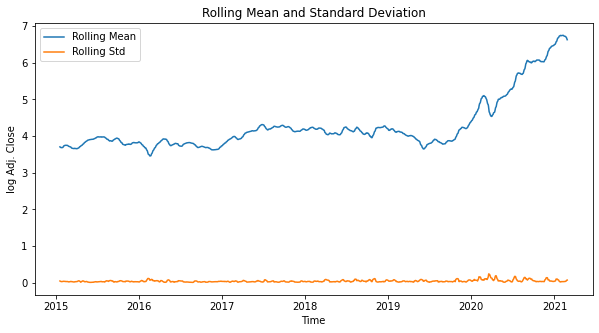

In [19]:
TSLA['log Adj. Close'] = np.log(TSLA['Adj. Close'])
TSLA_log_moving_avg = TSLA['log Adj. Close'].rolling(12).mean()
TSLA_log_std = TSLA['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(TSLA['Date'], TSLA_log_moving_avg, label = "Rolling Mean")
plt.plot(TSLA['Date'], TSLA_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

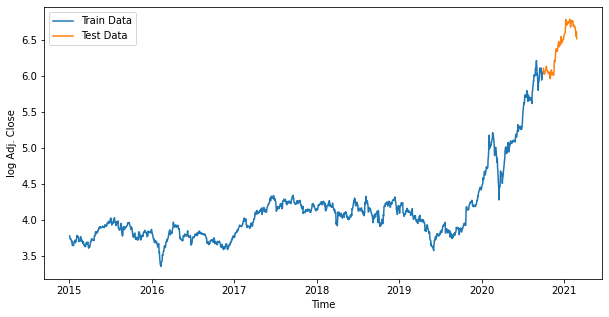

In [20]:
TSLA_Train_Data = TSLA[TSLA['Date'] < '2020-10-01']
TSLA_Test_Data = TSLA[TSLA['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(TSLA_Train_Data['Date'], TSLA_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(TSLA_Test_Data['Date'], TSLA_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [21]:
TSLA_Auto_ARIMA_Model = auto_arima(TSLA_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(TSLA_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(5, 2, 2)   Log Likelihood                2803.438
Date:                Wed, 03 Mar 2021   AIC                          -5588.875
Time:                        09:13:45   BIC                          -5541.392
Sample:                             0   HQIC                         -5571.153
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.908e-06   5.33e-05      0.167      0.867   -9.56e-05       0.000
ar.L1         -0.6933      7.704     -0.090      0.928     -15.793      14.407
ar.L2          0.0633      0.247      0.256      0.7

In [22]:
TSLA_ARIMA_Model = ARIMA(TSLA_Train_Data['log Adj. Close'], order = (5, 2, 2))
TSLA_ARIMA_Model_Fit = TSLA_ARIMA_Model.fit()
print(TSLA_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:      D2.log Adj. Close   No. Observations:                 1445
Model:                 ARIMA(5, 2, 2)   Log Likelihood                2811.906
Method:                       css-mle   S.D. of innovations              0.034
Date:                Wed, 03 Mar 2021   AIC                          -5605.812
Time:                        09:13:48   BIC                          -5558.329
Sample:                             2   HQIC                         -5588.089
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4.701e-06   3.63e-06      1.295      0.195   -2.41e-06    1.18e-05
ar.L1.D2.log Adj. Close    -0.7382      1.030     -0.717      0.474      -2.757       1.281


###Predicting the closing stock price of Tesla

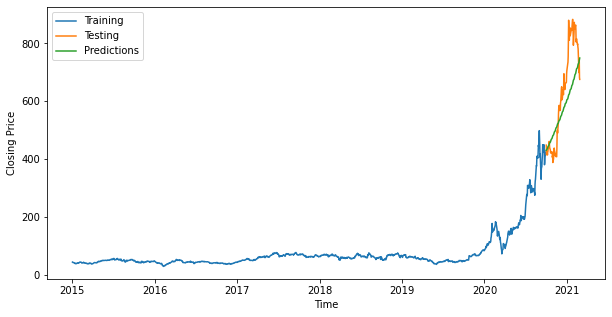

In [23]:
TSLA_output = TSLA_ARIMA_Model_Fit.forecast(102, alpha=0.05)
TSLA_predictions = np.exp(TSLA_output[0])
plt.figure(figsize=(10, 5))
plt.plot(TSLA_Train_Data['Date'], TSLA_Train_Data['Adj. Close'], label = 'Training')
plt.plot(TSLA_Test_Data['Date'], TSLA_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(TSLA_Test_Data['Date'], TSLA_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [24]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Data['Adj. Close'], TSLA_predictions))
mape = np.mean(np.abs(TSLA_predictions - TSLA_Test_Data['Adj. Close'])/np.abs(TSLA_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 108.11371680798878
MAPE: 0.1303704319549627


#Google

In [25]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [26]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [27]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

In [28]:
Test_Stationarity(GOOG)

Results of Dickey Fuller Test
Test Statistics: 0.6722962942047408
p-value: 0.9892684650395426
Number of lags used: 22
Number of observations used: 1526
critical value (1%): -3.4346424863111396
critical value (5%): -2.8634358661653803
critical value (10%): -2.5677793320839823


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

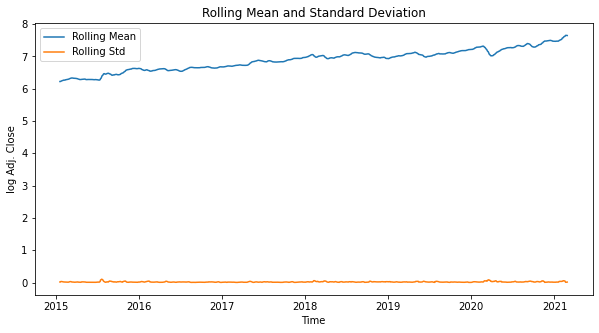

In [29]:
GOOG['log Adj. Close'] = np.log(GOOG['Adj. Close'])
GOOG_log_moving_avg = GOOG['log Adj. Close'].rolling(12).mean()
GOOG_log_std = GOOG['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(GOOG['Date'], GOOG_log_moving_avg, label = "Rolling Mean")
plt.plot(GOOG['Date'], GOOG_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

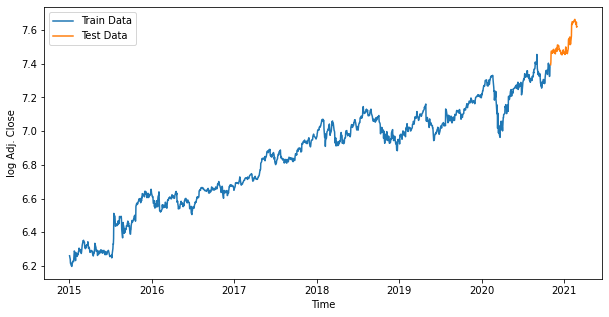

In [30]:
GOOG_Train_Data = GOOG[GOOG['Date'] < '2020-11-01']
GOOG_Test_Data = GOOG[GOOG['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(GOOG_Train_Data['Date'], GOOG_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(GOOG_Test_Data['Date'], GOOG_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [31]:
GOOG_Auto_ARIMA_Model = auto_arima(GOOG_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(GOOG_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3905.939
Date:                Wed, 03 Mar 2021   AIC                          -7805.878
Time:                        09:13:56   BIC                          -7790.003
Sample:                             0   HQIC                         -7799.958
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.882      0.060   -3.47e-05       0.002
ar.L1         -0.0876      0.015     -5.798      0.000      -0.117      -0.058
sigma2         0.0003   4.48e-06     63.886      0.0

In [32]:
GOOG_ARIMA_Model = ARIMA(GOOG_Train_Data['log Adj. Close'], order = (1, 1, 0))
GOOG_ARIMA_Model_Fit = GOOG_ARIMA_Model.fit()
print(GOOG_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.log Adj. Close   No. Observations:                 1468
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3905.939
Method:                       css-mle   S.D. of innovations              0.017
Date:                Wed, 03 Mar 2021   AIC                          -7805.879
Time:                        09:13:56   BIC                          -7790.004
Sample:                             1   HQIC                         -7799.958
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0008      0.000      1.896      0.058    -2.6e-05       0.002
ar.L1.D.log Adj. Close    -0.0877      0.026     -3.367      0.001      -0.139      -0.037
    

###Predicting the closing stock price of Google

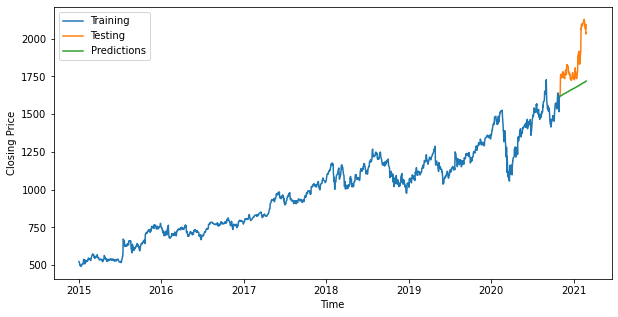

In [33]:
GOOG_output = GOOG_ARIMA_Model_Fit.forecast(80, alpha=0.05)
GOOG_predictions = np.exp(GOOG_output[0])
plt.figure(figsize=(10, 5))
plt.plot(GOOG_Train_Data['Date'], GOOG_Train_Data['Adj. Close'], label = 'Training')
plt.plot(GOOG_Test_Data['Date'], GOOG_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(GOOG_Test_Data['Date'], GOOG_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [34]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Data['Adj. Close'], GOOG_predictions))
mape = np.mean(np.abs(GOOG_predictions - GOOG_Test_Data['Adj. Close'])/np.abs(GOOG_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 210.40237555557943
MAPE: 0.09222702265794448


#Microsoft

In [35]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [36]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [37]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

In [38]:
Test_Stationarity(MSFT)

Results of Dickey Fuller Test
Test Statistics: 2.1271168914605765
p-value: 0.9988169756931882
Number of lags used: 24
Number of observations used: 1524
critical value (1%): -3.4346481290263013
critical value (5%): -2.8634383565975736
critical value (10%): -2.567780658251872


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

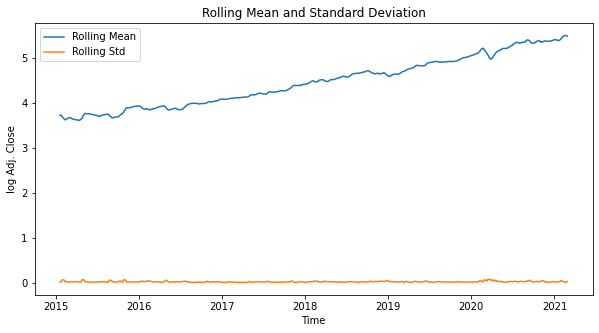

In [39]:
MSFT['log Adj. Close'] = np.log(MSFT['Adj. Close'])
MSFT_log_moving_avg = MSFT['log Adj. Close'].rolling(12).mean()
MSFT_log_std = MSFT['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(MSFT['Date'], MSFT_log_moving_avg, label = "Rolling Mean")
plt.plot(MSFT['Date'], MSFT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

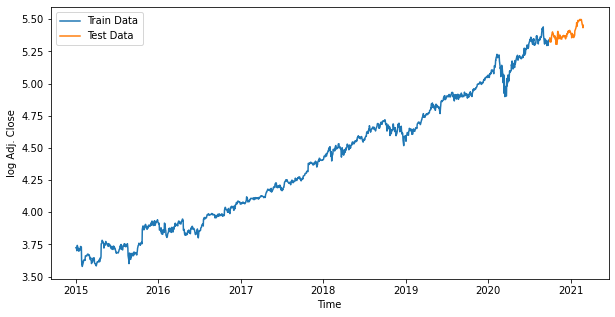

In [40]:
MSFT_Train_Data = MSFT[MSFT['Date'] < '2020-10-01']
MSFT_Test_Data = MSFT[MSFT['Date'] >= '2020-10-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(MSFT_Train_Data['Date'], MSFT_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(MSFT_Test_Data['Date'], MSFT_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [41]:
MSFT_Auto_ARIMA_Model = auto_arima(MSFT_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(MSFT_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1447
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3828.056
Date:                Wed, 03 Mar 2021   AIC                          -7650.112
Time:                        09:14:01   BIC                          -7634.282
Sample:                             0   HQIC                         -7644.204
                               - 1447                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.000      2.995      0.003       0.000       0.002
ar.L1         -0.2169      0.012    -18.786      0.000      -0.239      -0.194
sigma2         0.0003   5.01e-06     58.650      0.0

In [42]:
MSFT_ARIMA_Model = ARIMA(MSFT_Train_Data['log Adj. Close'], order = (1, 1, 0))
MSFT_ARIMA_Model_Fit = MSFT_ARIMA_Model.fit()
print(MSFT_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.log Adj. Close   No. Observations:                 1446
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3828.056
Method:                       css-mle   S.D. of innovations              0.017
Date:                Wed, 03 Mar 2021   AIC                          -7650.112
Time:                        09:14:01   BIC                          -7634.283
Sample:                             1   HQIC                         -7644.204
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0011      0.000      3.022      0.003       0.000       0.002
ar.L1.D.log Adj. Close    -0.2168      0.026     -8.445      0.000      -0.267      -0.166
    

###Predicting the closing stock price of Microsoft

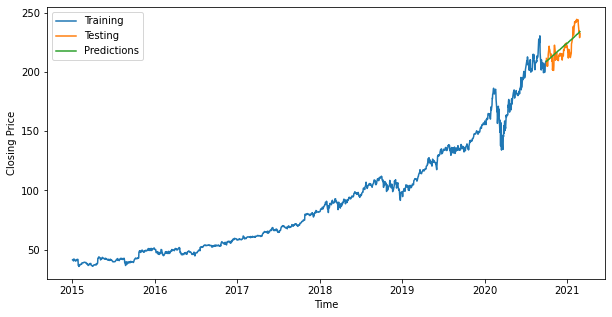

In [43]:
MSFT_output = MSFT_ARIMA_Model_Fit.forecast(102, alpha=0.05)
MSFT_predictions = np.exp(MSFT_output[0])
plt.figure(figsize=(10, 5))
plt.plot(MSFT_Train_Data['Date'], MSFT_Train_Data['Adj. Close'], label = 'Training')
plt.plot(MSFT_Test_Data['Date'], MSFT_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(MSFT_Test_Data['Date'], MSFT_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [44]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Data['Adj. Close'], MSFT_predictions))
mape = np.mean(np.abs(MSFT_predictions - MSFT_Test_Data['Adj. Close'])/np.abs(MSFT_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 7.269511877014612
MAPE: 0.027081038152935593


#Amazon

In [45]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [46]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [47]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

In [48]:
Test_Stationarity(AMZN)

Results of Dickey Fuller Test
Test Statistics: 0.2703409634404918
p-value: 0.9759420712303004
Number of lags used: 18
Number of observations used: 1530
critical value (1%): -3.434631245212095
critical value (5%): -2.8634309048528066
critical value (10%): -2.5677766901619035


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

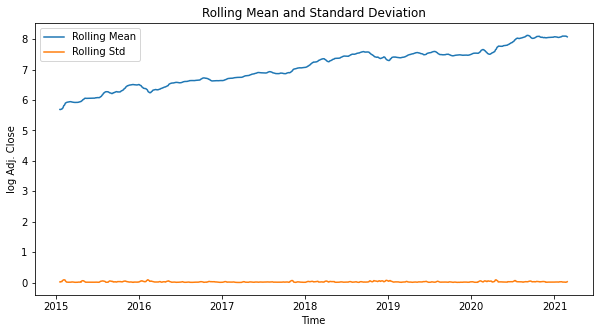

In [49]:
AMZN['log Adj. Close'] = np.log(AMZN['Adj. Close'])
AMZN_log_moving_avg = AMZN['log Adj. Close'].rolling(12).mean()
AMZN_log_std = AMZN['log Adj. Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(AMZN['Date'], AMZN_log_moving_avg, label = "Rolling Mean")
plt.plot(AMZN['Date'], AMZN_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

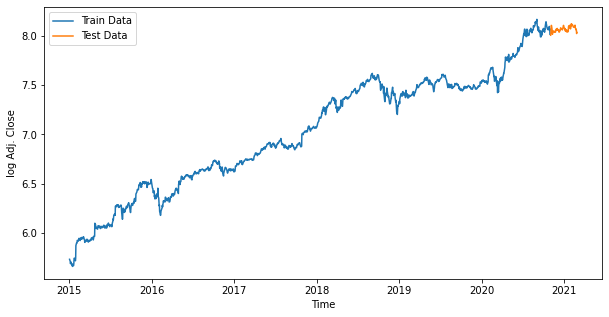

In [50]:
AMZN_Train_Data = AMZN[AMZN['Date'] < '2020-11-01']
AMZN_Test_Data = AMZN[AMZN['Date'] >= '2020-11-01'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(AMZN_Train_Data['Date'], AMZN_Train_Data['log Adj. Close'], label = 'Train Data')
plt.plot(AMZN_Test_Data['Date'], AMZN_Test_Data['log Adj. Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Adj. Close')
plt.legend(loc = 'best')

###Modeling

In [51]:
AMZN_Auto_ARIMA_Model = auto_arima(AMZN_Train_Data['log Adj. Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(AMZN_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1469
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3704.612
Date:                Wed, 03 Mar 2021   AIC                          -7405.225
Time:                        09:14:06   BIC                          -7394.641
Sample:                             0   HQIC                         -7401.278
                               - 1469                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.001      3.025      0.002       0.001       0.003
sigma2         0.0004   6.92e-06     54.419      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.40   Jarque-

In [52]:
AMZN_ARIMA_Model = ARIMA(AMZN_Train_Data['log Adj. Close'], order = (0, 1, 0))
AMZN_ARIMA_Model_Fit = AMZN_ARIMA_Model.fit()
print(AMZN_ARIMA_Model_Fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.log Adj. Close   No. Observations:                 1468
Model:                 ARIMA(0, 1, 0)   Log Likelihood                3704.612
Method:                           css   S.D. of innovations              0.019
Date:                Wed, 03 Mar 2021   AIC                          -7405.225
Time:                        09:14:06   BIC                          -7394.641
Sample:                             1   HQIC                         -7401.278
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      3.076      0.002       0.001       0.003


###Predicting the closing stock price of Amazon

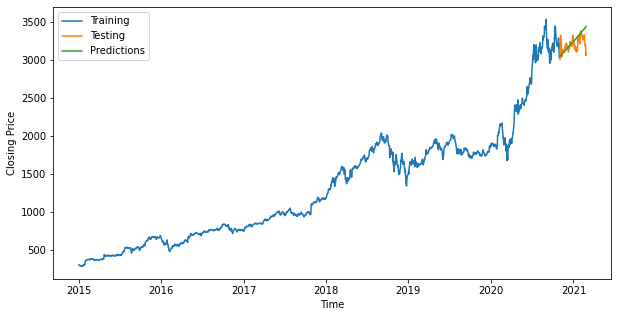

In [53]:
AMZN_output = AMZN_ARIMA_Model_Fit.forecast(80, alpha=0.05)
AMZN_predictions = np.exp(AMZN_output[0])
plt.figure(figsize=(10, 5))
plt.plot(AMZN_Train_Data['Date'], AMZN_Train_Data['Adj. Close'], label = 'Training')
plt.plot(AMZN_Test_Data['Date'], AMZN_Test_Data['Adj. Close'], label = 'Testing')
plt.plot(AMZN_Test_Data['Date'], AMZN_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [54]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Data['Adj. Close'], AMZN_predictions))
mape = np.mean(np.abs(AMZN_predictions - AMZN_Test_Data['Adj. Close'])/np.abs(AMZN_Test_Data['Adj. Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 113.18558052462348
MAPE: 0.02500054538949603
